In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)

In [3]:
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_box_office_revenue,movie_runtime,languages,countries,genres,imdb_id,cast,rating,votes,budget,plot,characters_names,main_character,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",228333.0,"['Natasha Henstridge', 'Ice Cube', 'Jason Stat...",4.9,55370.0,28000000.0,"Set in the second half of the 22nd century, th...","['Akooshay', 'Lieutenant Melanie Ballard', 'De...",Lieutenant Melanie Ballard,2001.0
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,['English'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,"[nan, nan]",NaN,1987.0
2,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,['German'],['Germany'],['Drama'],83949.0,"['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",6.0,591.0,NaN,"Eva, an upper class housewife, becomes frustra...","[nan, nan, nan]",NaN,1983.0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,['English'],['South Africa'],"['Family Film', 'Fantasy', 'Adventure', 'World...",NaN,NaN,NaN,NaN,NaN,"Every hundred years, the evil Morgana returns...","[nan, 'Morgana', nan, nan, nan, nan, nan, nan]",NaN,2002.0
4,6631279,/m/0gffwj,Little city,NaN,93.0,['English'],['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,NaN,NaN,NaN,NaN,"Adam, a San Francisco-based artist who works a...","[nan, 'Rebecca', 'Nina', nan, nan, nan]",Rebecca,1997.0


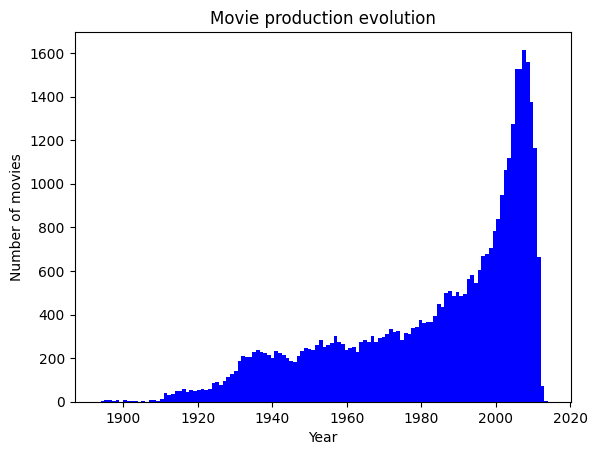

In [19]:
# 2.1 movie production evolution
fig, ax = plt.subplots()
ax.hist(df["release_year"], bins=(2014-1893+1), color="blue")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.show()

In [20]:
df["release_year"].describe()

count    39585.000000
mean      1983.639990
std         25.652412
min       1893.000000
25%       1966.000000
50%       1993.000000
75%       2005.000000
max       2014.000000
Name: release_year, dtype: float64

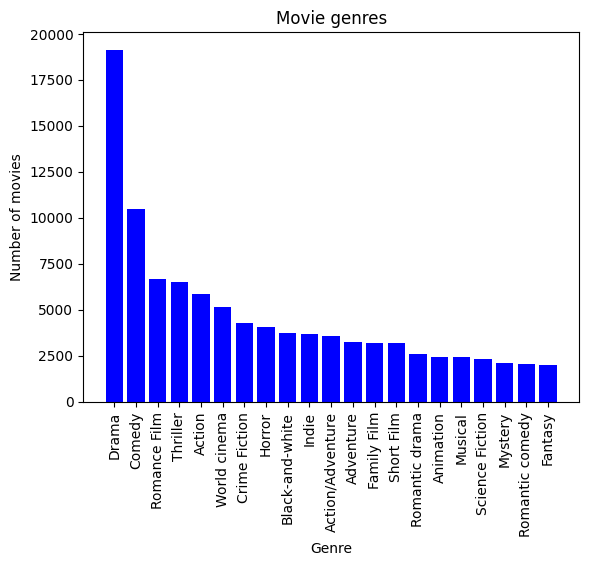

In [21]:

genres = df.genres.apply(lambda film: [genre for genre in literal_eval(film)]).explode().value_counts()
genres = genres[genres > 2000]
fig, ax = plt.subplots()
ax.bar(genres.index, genres.values, color="blue")
ax.set_xlabel("Genre")
ax.set_ylabel("Number of movies")
ax.set_title("Movie genres")
plt.xticks(rotation=90)
plt.show()

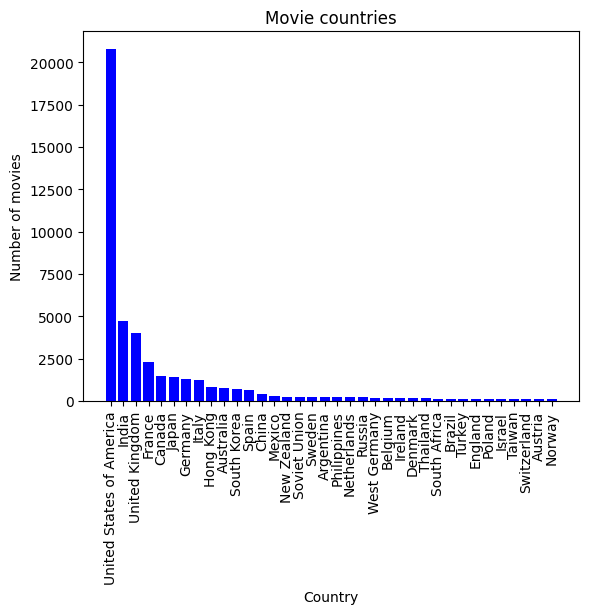

In [22]:
countries = df.countries.apply(lambda film: [country for country in literal_eval(film)]).explode().value_counts()
countries = countries[countries > 100]
fig, ax = plt.subplots()
ax.bar(countries.index, countries.values, color="blue")
ax.set_xlabel("Country")
ax.set_ylabel("Number of movies")
ax.set_title("Movie countries")
plt.xticks(rotation=90)
plt.show()

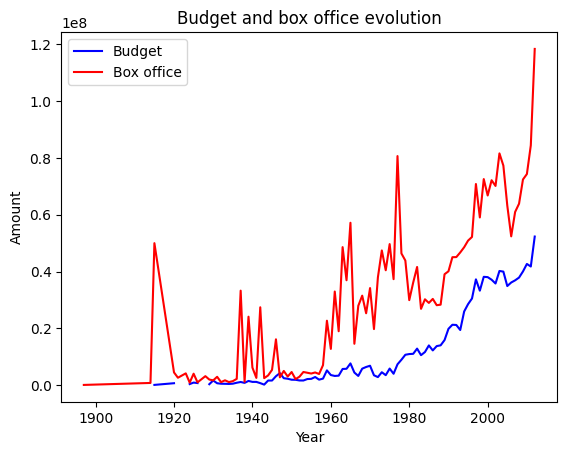

In [23]:
## for this one we need the revenue fetch from the API

fig, ax = plt.subplots()
box_office = df[df["movie_box_office_revenue"].notna()]
budget_by_year = box_office.groupby("release_year")["budget"].mean()
box_office_world_by_year = box_office.sort_values(["release_year"]).groupby("release_year")["movie_box_office_revenue"].mean()
ax.plot(budget_by_year.index, budget_by_year.values, color="blue", label="Budget")
ax.plot(box_office_world_by_year.index, box_office_world_by_year.values, color="red", label="Box office")
ax.set_xlabel("Year")
ax.set_ylabel("Amount")
ax.set_title("Budget and box office evolution")
ax.legend()
plt.show()